In [19]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [194]:
def loadData(fileName, fmt = 1):
    col = 'APN'
    converters = { 'APN': lambda x: x[4:] }
    if fmt == 2 or fmt == 3:
        col = 'BLKLOT'
        converters = None
    if fmt == 4:
        col = 'Block Lot'
        converters = None
        
    X = pd.read_csv(fileName, sep=',', parse_dates=[], infer_datetime_format=True, index_col=[col], quotechar='"', converters=converters)
    if fmt == 2 or fmt == 3:
        X = X.rename(columns={"AFF_UNITS_NET": "NET_AFF_UNITS"})
    if fmt == 3:
        X = X.rename(columns={"UNITSNET": "NET_UNITS"})
    if fmt == 4:
        X = X.rename(columns={"Units": "UNITS", "Net Added Units": "NET_UNITS", "Best Stat": "BESTSTAT"})
    X = X[X['BESTSTAT'] == 'CONSTRUCTION']
    return X

data = []

data.append(loadData('data/San_Francisco_Development_Pipeline_2013_Quarter_4.csv', 4))
data.append(loadData('data/San_Francisco_Development_Pipeline_2014_Quarter_1.csv', 4))
data.append(loadData('data/San_Francisco_Development_Pipeline_2014_Quarter_2.csv', 4))
data.append(loadData('data/San_Francisco_Development_Pipeline_2014_Quarter_3.csv', 4))
data.append(loadData('data/San_Francisco_Development_Pipeline_2014_Quarter_4.csv', 3))
data.append(loadData('data/San_Francisco_Development_Pipeline_2015_Quarter_1.csv', 2))
data.append(loadData('data/San_Francisco_Development_Pipeline_2015_Quarter_2.csv'))
data.append(loadData('data/San_Francisco_Development_Pipeline_2015_Quarter_3.csv'))
data.append(loadData('data/San_Francisco_Development_Pipeline_2015_Quarter_4.csv'))
data.append(loadData('data/SF_Development_Pipeline_2016_Q1.csv'))
data.append(loadData('data/SF_Development_Pipeline_2016_Q2.csv'))
data.append(loadData('data/SF_Development_Pipeline_2016_Q3.csv'))
data.append(loadData('data/SF_Development_Pipeline_2016_Q4.csv'))
data.append(loadData('data/SF_Development_Pipeline_2017_Q1.csv'))

In [195]:
data[0]

,ObjectID,Planning Neighborhood,BESTSTAT,Best Date,UNITS,Planning Project Description,DBI Project Description,Zoning_Generalized,Zoning_Simplified,TAZ,...,PARKING,PARKINGNET,SUPDIST,Sponsor Firm,Sponsor Name,CONTACTPHONE,FULLNAME,CONTACTCITY,CONTACTADD,Location 1
Block Lot,,,,,,,,,,,,,,,,,,,,,
0069011,94,Northeast,CONSTRUCTION,21-Jun-13,2.0,"Construction of a new 4-story, 2-unit resident...",TO ERECT A NEW FOUR STORY TWO FAMILY DWELLING ...,Residential,RH-3,849.0,...,NaN,NaN,2.0,Walker and Moody Architects,Dean Martelli,885-0800,Dean Martelli 885-0800,"San Francisco, CA 94109",2666 Hyde Street,"2626 Larkin St\n(37.802238000000003, -122.4210..."
0074001,96,Northeast,CONSTRUCTION,19-Nov-13,0.0,Library Bond project combined with Park Plan. ...,ERECT 2-STORY PUBLIC BRANCH LIBRARY,Mixed Use,NO BEACH,381.0,...,NaN,NaN,3.0,Branch Library Improvement Program,Mindy Linetsky,557-4427,Mindy Linetsky 557-4427,"San Francisco, CA 94103-2603",190 Ninth Street,"701 Lombard St\n(37.802619, -122.41321000000001)"
0133012,135,Northeast,CONSTRUCTION,13-Dec-12,3.0,RELOCATION AND UPGRADE OF EGRESS STAIRS IN REA...,"Seismic reinforcement front and rear, partial ...",Residential,RH-3,372.0,...,NaN,NaN,3.0,"RYNERSON OBRIEN ARCHITECTURE, INC",JACK McGUIRE,510-452-9152,JACK McGUIRE 510-452-9152,"OAKLAND, CA 94612",1512 FRANKLIN STREET,"414 Vallejo St\n(37.799306999999999, -122.404422)"
0165021,156,Northeast,CONSTRUCTION,02-Jan-14,75.0,Broadway/Sansome Family Housing: 100% affordab...,ERECT A FIVE STORY RESIDENTIAL & COMMERCIAL BU...,Commercial,C-2,826.0,...,0.0,-25.0,3.0,Chinatown CDC,Kim Piechota,929-0712,Kim Piechota 929-0712,"San Francisco, CA 94109",1515 Vallejo St,"235 Broadway\n(37.798507499999999, -122.4016044)"
0279011,195,Downtown,CONSTRUCTION,24-Apr-13,35.0,The project site is current vacant and used as...,NaN,Mixed Use,RC-4,322.0,...,13.0,-4361.0,3.0,"JS Sullivan Development, LLC",Sean Sullivan,415.206.1578,Sean Sullivan 415.206.1578,"San Francisco, CA 94110",1699 Valencia Street,"1080 Sutter St\n(37.788226399999999, -122.4180..."
0297009,216,Downtown,CONSTRUCTION,03-Jan-13,17.0,NaN,"Revision to previous approved permits, 2008/04...",Commercial,C-3-G,736.0,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,"693 Sutter St\n(37.788662899999999, -122.41164..."
0339006,272,Downtown,CONSTRUCTION,04-Nov-13,9.0,convert vacant commercial building (retail / b...,CONVERSION OF (E) 3 STORY OVER BASEMENT BLDG. ...,Mixed Use,RC-4,304.0,...,NaN,NaN,6.0,"Shatara Architecture, Inc.",Suheil Shatara,415-512-7566,Suheil Shatara 415-512-7566,"San Francisco, CA 94107",522 2nd Street,"130 Turk St\n(37.783413000000003, -122.411457)"
0349001,293,Downtown,CONSTRUCTION,30-Dec-13,90.0,Ten story mixed-use affordable housing project...,"ERECT 10 STORIES, 90 DWELLING UNITS, 1 BASEMEN...",Mixed Use,RC-4,296.0,...,NaN,NaN,6.0,Reuben & Junius,Joel Yodowitz,415 567 9000,Joel Yodowitz 415 567 9000,"San Francisco, CA 94104","1 Bush Street, Suite 600","101 Golden Gate Av\n(37.781936000000002, -122...."
0510029,336,Marina,CONSTRUCTION,16-Dec-13,3.0,NaN,TO COMPLY WITH NOV#200665975 TO ESTABLISH LEGA...,Mixed Use,NC-3,815.0,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,"2157 Lombard St\n(37.799470900000003, -122.436..."


In [199]:
preprocessed = []
for i in range(len(data)):
    X = data[i]
    X = X[X['UNITS'] >= 0]
    X = X[X['NET_UNITS'] >= 0]
    # X = X[X['NET_UNITS'] > X['UNITS']]
    preprocessed.append(X)
    
completed = []
for i in range(len(preprocessed)-1):
    completed.append(preprocessed[i][~preprocessed[i].index.isin(preprocessed[i+1].index)])
buildings = list(map(lambda x: len(x), completed))
units = list(map(lambda x: x['NET_UNITS'].values.sum(), completed))
units2 = list(map(lambda x: x['UNITS'].values.sum(), completed))
# affUnits = list(map(lambda x: x['AFF_UNITS'].values.sum(), completed))
# netAffUnits = list(map(lambda x: x['NET_AFF_UNITS'].values.sum(), completed))
print("Buildings: {}".format(buildings))
print("Net Units: {}".format(units))
print("Total Units: {}".format(sum(units)))
# print("Net Affordable Units: {}".format(netAffUnits))

Buildings: [19, 37, 53, 56, 52, 71, 39, 26, 81, 28, 37, 48, 54]
Net Units: [1672.0, 1371.0, 1856.0, 1763.0, 2096, 3546, 2457, 950, 1927, 616, 864, 1037, 977]
Total Units: 21132.0


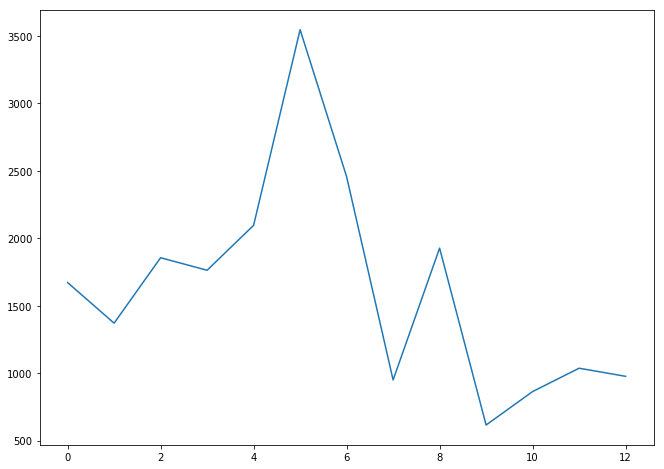

In [197]:
fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)

ax1.plot(range(len(data)-1), units, label='total')
# ax1.plot(range(len(data)-1), netAffUnits, label='affordable')